## Sliding window implementation

In [1]:
%matplotlib inline

In [2]:
import time

from threading import Lock 
from typing import Optional


class TumblingWindow:
    _time_window: int
    _start_time: float
    _locker: Lock
    _counter: int

    def __init__(self, time_window: int, start_time: Optional[float] = None):
        assert time_window > 0

        self._time_window = time_window
        self._start_time = start_time if start_time is not None else time.time()
        self._end_time = self._start_time + self._time_window
        self._locker = Lock()
        self._counter = 0

    def _anti_entrophy(self, current_time: int) -> None:
        if self._end_time < current_time:
            empty_slots = int((current_time - self._end_time) / self._time_window)

            self._start_time = self._end_time + empty_slots * self._time_window
            self._end_time = self._start_time + self._time_window
            self._counter = 0

    def update(self, diff: int, current_time: Optional[float] = None) -> None:
        with self._locker:
            if not current_time:
                current_time = time.time()

            self._anti_entrophy(current_time)

            self._counter += diff

    @property
    def val(self) -> int:
        with self._locker:
            self._anti_entrophy(time.time())

            return self._counter

In [3]:
TW = TumblingWindow(5)

TW.update(1)
TW.update(2)
TW.update(3)
TW.update(4)
print(TW.val) # expect 10

time.sleep(5)

TW.update(5)
TW.update(6)
print(TW.val) # expect 11

10
11


In [4]:
import time
import math

from threading import Lock 
from typing import Optional, Deque
from collections import deque


class HoppingWindow:
    _time_window: int
    _hopping_window: int
    _start_time: float
    _locker: Lock
    _windows: Deque[int]

    def __init__(self, time_window: int, hopping_window: int, start_time: Optional[float] = None):
        assert time_window > 0
        assert time_window > hopping_window
        assert time_window % hopping_window == 0

        self._time_window = time_window
        self._hopping_window = hopping_window
        self._start_time = start_time if start_time is not None else time.time()
        self._end_time = self._start_time + self._time_window
        self._slots = self._time_window // self._hopping_window
        self._locker = Lock()
        self._windows = deque([0] * self._slots)
    
    def _anti_entrophy(self, current_time: int) -> None:
        if self._end_time < current_time:
            removed_slots = math.ceil((current_time - self._start_time) / self._hopping_window) - self._slots

            self._start_time = self._start_time + removed_slots * self._hopping_window
            self._end_time = self._start_time + self._time_window

            if removed_slots >= self._slots:
                self._windows = deque([0] * (self._time_window // self._hopping_window))
                return

            while removed_slots > 0:
                self._windows.popleft()
                self._windows.append(0)

                removed_slots -= 1

    def update(self, diff: int, current_time: Optional[float] = None) -> None:
        with self._locker:
            if not current_time:
                current_time = time.time()

            self._anti_entrophy(current_time)

            self._windows[int((current_time - self._start_time) / self._hopping_window)] += diff

    @property
    def val(self, current_time: Optional[float] = None) -> int:
        with self._locker:
            if not current_time:
                current_time = time.time()

            self._anti_entrophy(current_time)

            return sum(self._windows)

In [5]:
HW = HoppingWindow(time_window=5, hopping_window=1)

HW.update(1)
time.sleep(1)

HW.update(2)
time.sleep(1)

HW.update(3)
time.sleep(1)

HW.update(4)
time.sleep(1)

HW.update(5)
print(HW.val) # expect 15

time.sleep(1)

HW.update(6)
print(HW.val) # expect 20

time.sleep(1)

HW.update(7)
print(HW.val) # expect 25

15
20
25


In [6]:
import threading

class CountDownLatch(object):
    def __init__(self, count=1):
        self.count = count
        self.lock = threading.Condition()

    def count_down(self):
        self.lock.acquire()
        self.count -= 1
        if self.count <= 0:
            self.lock.notifyAll()
        self.lock.release()

    def wait(self):
        self.lock.acquire()
        while self.count > 0:
            self.lock.wait()
        self.lock.release()

In [7]:
import random

In [8]:
def random_val():
    return random.randrange(0, 100)

In [9]:
import threading

from collections import deque


num_of_threads = 4
cdl = CountDownLatch(num_of_threads)
records = {}
start_time = time.time()


def create_target(name):
    TW = TumblingWindow(5, start_time)
    records[name] = deque()

    def target():
        count = 0
        total_count = 0

        while True:
            TW.update(random_val())

            count += 1
            total_count += 1

            if count == 100:
                time.sleep(random.random())

            if count == 1000:
                count = 0

                records[name].append(TW.val)

            if total_count == 100000:
                break

        cdl.count_down()

    return target


for i in range(num_of_threads):
    thread = threading.Thread(target=create_target(f'TW{i}'))
    thread.start()


cdl.wait()

In [10]:
import pandas as pd

df = pd.DataFrame(data=records)

In [11]:
df.head()

,TW0,TW1,TW2,TW3
0,49672,49915,48870,51170
1,99552,99820,98264,100624
2,148533,148795,148803,150281
3,197658,199959,197641,199161
4,246138,250086,247798,249249


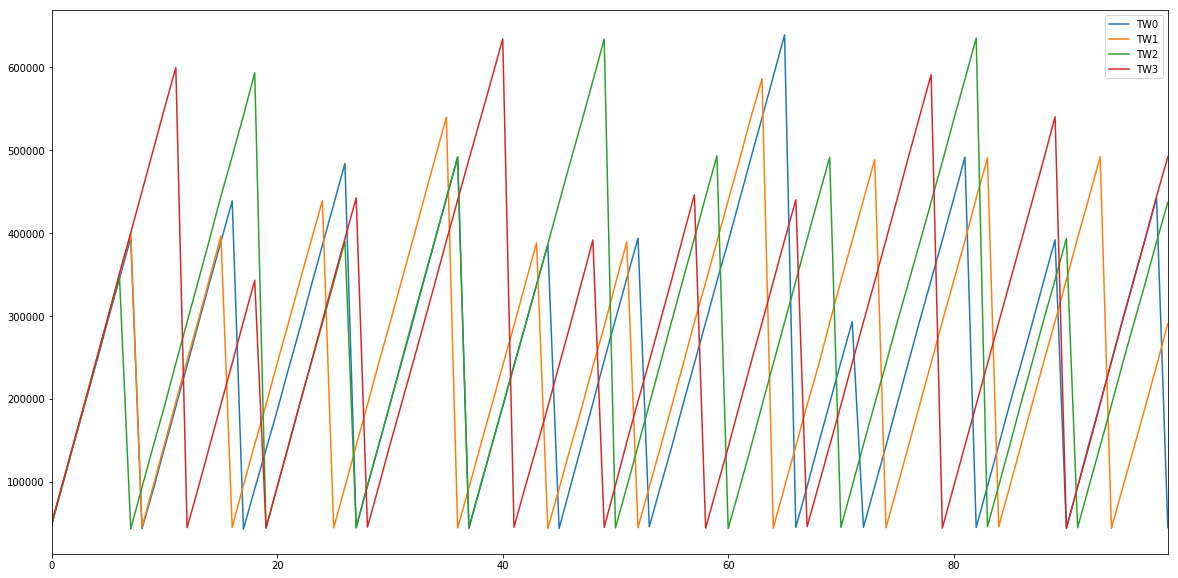

In [12]:
df.plot(figsize=(20,10))

In [13]:
import threading

from collections import deque


num_of_threads = 4
cdl = CountDownLatch(num_of_threads)
records = {}
start_time = time.time()


def create_target(name):
    HW = HoppingWindow(5, 1, start_time)
    records[name] = deque()

    def target():
        count = 0
        total_count = 0

        while True:
            HW.update(random_val())

            count += 1
            total_count += 1

            if count == 100:
                time.sleep(random.random())

            if count == 1000:
                count = 0

                records[name].append(HW.val)

            if total_count == 100000:
                break

        cdl.count_down()

    return target


for i in range(num_of_threads):
    thread = threading.Thread(target=create_target(f'TW{i}'))
    thread.start()


cdl.wait()

In [14]:
df = pd.DataFrame(data=records)

In [15]:
df.head()

,TW0,TW1,TW2,TW3
0,49777,48201,51404,48873
1,98764,95196,101781,99083
2,148969,145095,152710,149631
3,198506,196456,202840,198801
4,247102,247932,251068,248771


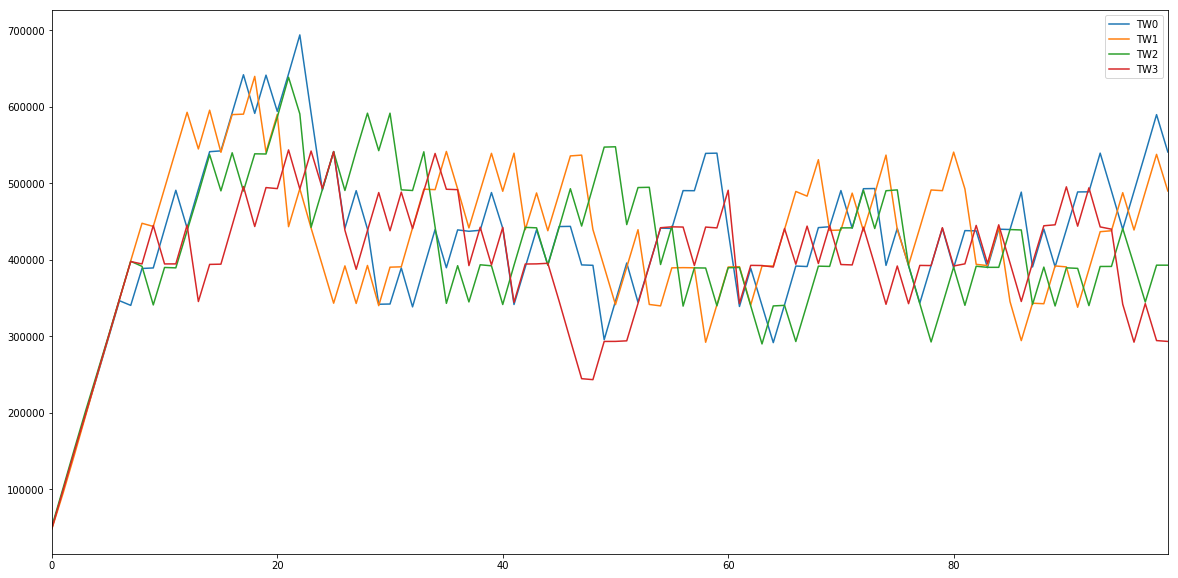

In [16]:
df.plot(figsize=(20,10))